Import necessary dependencies.

In [2]:
import uuid
from typing import cast, Literal
from IPython.core.display_functions import display
from gen_ai_hub.proxy.langchain import init_llm
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.types import interrupt, Command, Send
from pydantic import Field, BaseModel

First, we need to initialize the large language model the agent will use to perform actions and respond to the users request. Here we use gpt-4o as the underlying language model, a maximum token count of 1024 and a temperature of zero to minimize uncertainty. A temperature of zero will lead to consistent result. However, the model output is not absolutely deterministic as the underlying caluclations are inherently undeterministic.
> **Note:** In order to initialize the language model the relevant environment variables need to be set (see Setup).

After initializing the LLM, we need give the agent access to the necessary tools.
We import three functions. `get_records`, `post_records`, and `get_today` from the timesheet_tools module. These functions interact with the SuccessFactors Employee Central API:
- `get_records`: Retrieves existing timesheet entries.
- `post_records`: Submits new timesheet entries.
- `get_today`: Fetches the current date.

We bind the tools to the LLM. This allows the model to specify tool calls when it deems relevant.
For a more detailed view on the tools see the appendix.


In [4]:
llm = init_llm('gpt-4o', max_tokens=1024, temperature=0)

from time_tools import get_records, post_records, get_today

agent_tools = [get_records, post_records, get_today]
agent_llm = llm.bind_tools(agent_tools)

In order to ensure consistent and useful behaviour we need to define a well structured system prompt next. 
Generally, you should:
  1. Define the role and persona.
  2. Establish context and objectives
  3. Outline clear instructions and constraints
  4. Provide examples of ideal responses (Optional)


By utilizing few-shot prompting model performance can be hugely improved. It also makes sense to encourage iterative clarification.

In [ ]:
system_prompt ="""
Role and Objective:

  - You are a helpful AI Agent dedicated to assisting users with their timesheet management.
  - Your primary tasks include retrieving and posting timesheet data based on user requests.

Responsibilities:

  - Logging Work Time: Only log actual work time. Do not include any breaks.
    - User: Today I worked from 6 to 16 with a half hour break at 12. -> You should: Log time from 6 to 12 and from 12:30 to 16.
  - Data Handling: When posting records, execute as many post_records calls in parallel as possible using the provided information.
  - Automatic Confirmation: When a post_records call is made, the user is automatically asked for confirmation over a GUI; do not prompt for confirmation.

Interaction Guidelines:

  - The user's most recent input always takes precedence over older input.
  - Language Consistency: Always respond in the same language as the user.
  - Clarity and Accuracy:
    - If any part of the user’s request is ambiguous (for example, missing dates or unclear work times), ask clarifying questions rather than making assumptions.
    - Ensure all necessary details are provided before proceeding with any action.
"""

prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),
    MessagesPlaceholder(variable_name='msg')
])

Now we come to actually building our agent.
As previously outlined, our agent consists of three nodes:

- the agent node: executing LLM calls,
- the review node: prompting the user for confirmation before mutative action
- the tool node: executing tools specified in the agent's response
  
When a node is called it is passed the graph state. We use the prebuilt AgentState which defines a variable messages by subclassing TypedDict. This is simply a list of messages which is passed to the language model at every invocation.

In [6]:
def agent(state: AgentState, config: RunnableConfig):
    model_input = prompt.invoke({'msg': state['messages']})
    response = cast(AIMessage, agent_llm.invoke(model_input, config))
    response.name = "agent"
    return {"messages": [response]}


Next we define the review node. For simplicity, we use only text input for verification. A more robust approach (used in the actual demo) can be found in the appendix. Here we use an additional language model for verificication. 
We use a workaround to get structured output from our model as of now structured_output is not supported. For this we bind a tool the model should use to structure its response.

In [7]:

class UserAffirmation(BaseModel):
    """Always use this tool to structure your response."""
    user_affirmation: bool = Field(description="Whether the user confirmed the action.")
    explanation: str = Field(description="An explanation of your decision.")

verification_llm = llm.bind_tools([UserAffirmation])


When control is passed to the review node, the post requests from the agent's response are fetched. If no post request is present, execution is resumed with the tools node. This is done by returning a Send object which routes execution. Otherwise the user is asked for confirmation with an interrupt. In contrast to Python's interrupt, execution is not resumed from the interrupt point, but rather the last node is executed again from top to bottom. This can be a common pitfall. When the user has supplied a response, we call a language model to process the user's input and retrieve the structured response. If the user approves we continue execution with the tool node. Otherwise, we update the state by appending a Tool Message and resume execution with the agent node. It is strictly necessary to append a Tool Message as most model providers require every tool call to be accompanied by a corresponding Tool Message.

In [8]:
from typing import Union


def human_review(state: AgentState) -> Command[Literal["agent", "tools"]]:
    last_message = state["messages"][-1]
    post_calls = [tool_call for tool_call in last_message.tool_calls if tool_call['name'] == 'post_records']

    if len(post_calls) > 0:
        confirmation_messages = [post_call["args"]["confirmation_messages"] for post_call in post_calls]
        user_review = interrupt({"task": "Review the action.",
                           "action": confirmation_messages})
        
        output = verification_llm.invoke(
            [('user', user_review), ('system', 'Verify whether the user wants to continue with the action.')])
        should_continue = output.tool_calls[0]['args']['user_affirmation']
        print(f"Model explanation: {output.tool_calls[0]['args']['explanation']}")
        if should_continue:
            return Send(node='tools', arg=state)
        else:
            return Command(update={"messages": [ToolMessage('User did not confirm action.', tool_call_id=post_call['id']) for post_call in post_calls]}, goto='agent')


    else:
        return Send(node='tools', arg=state)


For the tools node we use the prebuilt ToolNode. It retrieves the tool calls from the last AIMessage and executes them. It provides a tool message for every tool call and appends it to the message history.

In [9]:
tool_node = ToolNode(agent_tools)

Now we build our graph by adding the nodes and edges. Edges define what nodes to execute next.

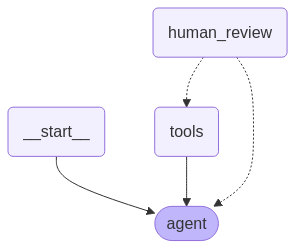

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__(<p>__start__</p>)
	agent([agent]):::last
	tools(tools)
	human_review(human_review)
	__start__ --> agent;
	tools --> agent;
	human_review -.-> agent;
	human_review -.-> tools;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [ ]:

workflow = StateGraph(AgentState)

workflow.add_node('agent', agent)
workflow.add_node('tools', tool_node)
workflow.add_node('human_review', human_review)

workflow.add_edge(START, "agent")
workflow.add_edge("tools", "agent")


display(workflow.compile())

Conditional edges define what node to execute next based on a condition. We add a conditional edge which routes the execution from the agent node either to the review node or the end node depending on whether the language model executed a tool call. 

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


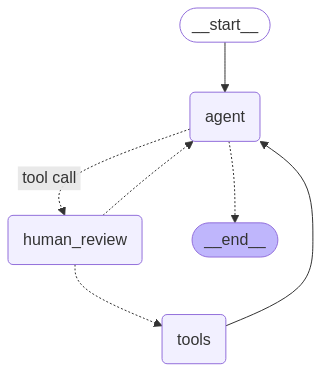

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools)
	human_review(human_review)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	tools --> agent;
	agent -. &nbsp;tool call&nbsp; .-> human_review;
	agent -.-> __end__;
	human_review -.-> agent;
	human_review -.-> tools;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [ ]:
def should_continue(state: AgentState) -> Literal["tools", "__end__"]:
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool call"
    return "__end__"

workflow.add_conditional_edges(source="agent", path=should_continue, path_map={"tool call": "human_review", "__end__": END})


display(workflow.compile())

Finally, we compile our graph. When compiling we add a checkpointer to achieve thread level persistence. With a checkpointer specified at compilation, a snapshot of the graph state is saved at every superstep. This is crucial for human-in-the-loop interactions as we need to resume execution after an interrupt is called. 



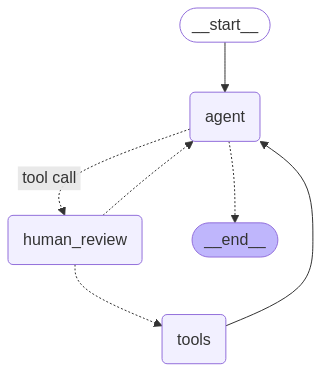

In [10]:

checkpointer = MemorySaver()
timesheet_agent = workflow.compile(checkpointer=checkpointer)
display(timesheet_agent)


In [11]:
def process_output(stream):
    for token in stream: 
        (key, content), = token.items()
        if key == "__interrupt__":
           print(content[0])
           return True 
        if content is not None:
           content['messages'][-1].pretty_print()
    print("\n")
    return False


Now we can stream the output of our agent. We hand over a dictionary containing the user's input and a config with our thread id. Each thread represents an individual session betweeen the graph and the user. So, if we want to continue our conversation, we need to pass the same thread id to the graph.

In [12]:

config = {"configurable": {"thread_id": str(uuid.uuid1())}}

user_input = {'messages': ['user', 'Today I worked from 6 to 6 with a half hour break at 12.']}
process_output(timesheet_agent.stream(user_input, config, stream_mode='updates'))

user_input = Command(resume='Sure.')
process_output(timesheet_agent.stream(user_input, config, stream_mode='updates'))




================================== Ai Message ==================================
Name: agent

To log your work time accurately, I will exclude the half-hour break from your total work hours. 

Your work hours are:
- From 06:00 to 12:00 (6 hours)
- From 12:30 to 18:00 (5.5 hours)

Total work hours: 11.5 hours

I will now log these work hours for today. Let me first retrieve today's date.
Tool Calls:
  get_today (call_rHtgYYzDZ5aTvTwyzf4oCmk1)
 Call ID: call_rHtgYYzDZ5aTvTwyzf4oCmk1
  Args:
================================= Tool Message =================================
Name: get_today

2025-03-11
================================== Ai Message ==================================
Name: agent
Tool Calls:
  post_records (call_uHlGJYSAiPqzwWkdBnoFudoh)
 Call ID: call_uHlGJYSAiPqzwWkdBnoFudoh
  Args:
    data: {'startDate': '2025-03-11', 'startTime': 'PT06H00M00S', 'endTime': 'PT12H00M00S'}
    confirmation_messages: Would you like to log your work hours from 06:00 to 12:00 on March 11th 2025?


False

Now you can try interacting with the agent.

In [13]:

config = {"configurable": {"thread_id": str(uuid.uuid1())}}
interrupted = False

print("Type to interact with the agent (type q to quit):\n")
while True:
    user_input = input()
    if user_input.lower() == 'q':
        break
    print(user_input)

    if interrupted:
        interrupted = False
        user_input = Command(resume=user_input)
    else:
        user_input = {'messages': ['user', user_input]}

    interrupted = process_output(timesheet_agent.stream(user_input, config, stream_mode="updates"))
      



Type to interact with the agent (type q to quit):

worked from 10 to 11
================================== Ai Message ==================================
Name: agent

Please provide the date on which you worked from 10:00 to 11:00. This will help me log your work time accurately.


yesterday
================================== Ai Message ==================================
Name: agent
Tool Calls:
  get_today (call_dtYYuTiZKB6TI8OIhtQSyMbZ)
 Call ID: call_dtYYuTiZKB6TI8OIhtQSyMbZ
  Args:
================================= Tool Message =================================
Name: get_today

2025-03-11
================================== Ai Message ==================================
Name: agent

I will log your work time from 10:00 to 11:00 on 2025-03-10 (yesterday).

Proceeding to post the record.
Tool Calls:
  post_records (call_P6bfNYrinCaR4tjLdetMNEjP)
 Call ID: call_P6bfNYrinCaR4tjLdetMNEjP
  Args:
    data: {'startDate': '2025-03-10', 'startTime': 'PT10H00M00S', 'endTime': 'PT11H00M00S'}
    